In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from albumentations import *
from skimage.transform import resize

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

from keras.layers import *
from keras.callbacks import *
from keras.optimizers import *
from keras.models import load_model, Model

import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [2]:
SHAPE = (224, 224, 3)
BATCH_SIZE = 24
EPOCHS = 100
N_SPLITS = 5
SEED = 1881
TRAIN_TEST_RATIO = 0.2

BASE_DIR     = "../../data/BreaKHis_v1/histology_slides/breast/"
DATASET_MODE = ["40X", "100X", "200X", "400X"]

In [3]:
class BREAKHIST_DATASET:
    
    """
    input_shape           --> TUPLE.wanted image size
    batch_size            --> INT.yielding data size for every iteration
    orders                --> LIST.which images will be used. max=len(all_images). it can be used for K-fold(CV).
    base_dir              --> STR.the DIR which is include "benign" and "malignant" dirs.
    dataset_mode          --> STR. Which type of images will be used: "40X", "100X", "200X", "400X".
    seed                  --> INT. This allow to dataset generator to more reproduciable and it ensures that x and y are shuffled with compatible.
    augment               --> BOOL. Augment data or not.
    train_test_ratio      --> How much of data will be used as test set.
    ---------
    GENERAL_CLASSES       --> LIST.["benign", "malignant"]
    BENIGN_SUB_CLASSES    --> LIST.["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"]
    MALIGNANT_SUB_CLASSES --> LIST.["ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"]
    """
    
    def __init__(self, input_shape, batch_size, orders, base_dir, dataset_mode, seed, train_test_ratio, augment=True):
        self.SHAPE                 = input_shape
        self.BATCH_SIZE            = batch_size
        self.arr                   = orders
        self.DATASET_MODE          = dataset_mode
        self.SEED                  = seed
        self.TT_RATIO              = train_test_ratio
        self.AUG                   = augment
        
        self.BASE_DIR              = base_dir
        self.GENERAL_CLASSES       = ["benign", "malignant"]
        self.BENIGN_SUB_CLASSES    = ["adenosis", "fibroadenoma", "phyllodes_tumor", "tubular_adenoma"]
        self.MALIGNANT_SUB_CLASSES = ["ductal_carcinoma", "lobular_carcinoma", "mucinous_carcinoma", "papillary_carcinoma"]
        
        
    def get_paths_n_labels(self):

        x      = []
        label = []
        
        for data_mode in self.DATASET_MODE:
            for ix1, a in enumerate(self.GENERAL_CLASSES):
                if ix1 == 0:
                    for ix2, b in enumerate(self.BENIGN_SUB_CLASSES):
                        path1 = self.BASE_DIR+a+"/SOB/"+b
                        for c in os.listdir(path1):
                            path2 = path1+"/"+c+"/"+data_mode
                            for img_name in os.listdir(path2):
                                path3 = path2+"/"+img_name

                                # x
                                img_path = path3 #np.array(Image.open(path3), dtype=np.float16)

                                # y
                                main_targets = np.zeros((2), dtype=np.float32) # BENIGN OR MALIGNANT
                                main_targets[ix1] = 1.

                                # Store the values
                                x.append(img_path)
                                label.append(main_targets)


                if ix1 == 1:
                    for ix2, b in enumerate(self.MALIGNANT_SUB_CLASSES):
                        path1 = self.BASE_DIR+a+"/SOB/"+b
                        for c in os.listdir(path1):
                            path2 = path1+"/"+c+"/"+data_mode
                            for img_name in os.listdir(path2):
                                path3 = path2+"/"+img_name

                                # x
                                img_path = path3  #np.array(Image.open(path3), dtype=np.float16)

                                # y
                                main_targets = np.zeros((2), dtype=np.float32) # BENIGN OR MALIGNANT
                                main_targets[ix1] = 1.

                                # Store the values
                                x.append(img_path)
                                label.append(main_targets)
                           
        return x, label
    
    def __len__(self):
        return len(self.get_paths_n_labels()[0])
    
    def get_img(self, img_path):
        img = Image.open(img_path)
        return np.array(img)
    
    def augmenting(self, img):
        if self.AUG:
            augment = Compose([VerticalFlip(p=0.5),
                               HorizontalFlip(p=0.5),
                               RandomBrightnessContrast(p=0.3),
                               ShiftScaleRotate(p=0.5, shift_limit=0.2, scale_limit=0.2, rotate_limit=20)])  
        else:
            augment = Compose([])  

        img = augment(image=img)['image']
        return img
    
    
    def resize_and_normalize(self, img):
        img = resize(img, self.SHAPE)
        return img
    
    def get_shuffled_data(self):
        img_paths, labels = self.get_paths_n_labels()

        np.random.seed(self.SEED) 
        np.random.shuffle(img_paths)
        
        np.random.seed(self.SEED) 
        np.random.shuffle(labels)
        
        return img_paths, labels
        
    def split_train_test(self, get):  # get=={"train","test"}
        img_paths, labels = self.get_shuffled_data()
        x_train, x_test, y_train, y_test = train_test_split(img_paths, labels, test_size=self.TT_RATIO, random_state=self.SEED)
        
        if get=='train':
            return x_train, y_train
        
        elif get=='test':
            return x_test, y_test
    
    def data_generator(self):
        img_paths, labels = self.split_train_test(get="train")
        
        while True:
            x = np.empty((self.BATCH_SIZE,)+self.SHAPE, dtype=np.float32)
            y = np.empty((self.BATCH_SIZE, 2), dtype=np.float32)

            batch = np.random.choice(self.arr, self.BATCH_SIZE)

            for ix, id_ in enumerate(batch):
                # x
                img_path = img_paths[id_]
                img = self.get_img(img_path)
                img = self.augmenting(img)
                img = self.resize_and_normalize(img)
                  
                # y 
                label = labels[id_]
             
                # Store the values    
                x[ix] = img
                y[ix] = label

            yield x, y

[[[[0.96139485 0.789196   0.9649072 ]
   [0.9472426  0.7278077  0.95245755]
   [1.         0.81538206 1.        ]
   ...
   [0.80110735 0.6296393  0.8869923 ]
   [0.7864233  0.59707415 0.85365456]
   [0.903648   0.7380646  0.92430407]]

  [[0.8504224  0.6910736  0.87844014]
   [0.86077994 0.6560662  0.87562585]
   [1.         0.8905221  1.        ]
   ...
   [0.8559283  0.67013085 0.927823  ]
   [0.7894608  0.5870098  0.8516041 ]
   [0.93349963 0.7578366  0.9683714 ]]

  [[0.7762211  0.62395614 0.8118916 ]
   [0.76394    0.5808736  0.79517245]
   [0.9914544  0.8570553  1.        ]
   ...
   [0.8757375  0.69534534 0.9485382 ]
   [0.77757573 0.57512474 0.8410561 ]
   [0.9268404  0.7470588  0.98689383]]

  ...

  [[0.85350794 0.67159486 0.89901084]
   [0.77699363 0.58301604 0.87359726]
   [0.8206517  0.6105961  0.89441967]
   ...
   [0.8488445  0.671387   0.92628896]
   [0.8475359  0.67444855 0.9203059 ]
   [0.82730436 0.69131    0.8970873 ]]

  [[0.85300684 0.65861124 0.88056725]
   [0.8

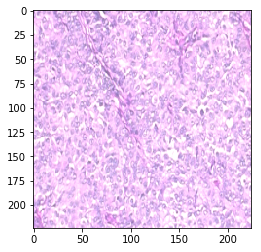

In [4]:
dataset = BREAKHIST_DATASET(SHAPE, 1, range(4), BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=True)

for ix, data in enumerate(dataset.data_generator()):
    img, y = data
    print(img)
    print(img.shape)
    print("-"*10)
    print(y)
    print(y.shape)
    print("-"*10)
    print(img[0,:,:,:].shape)
    plt.imshow(img[0,:,:,:])
    plt.show()
    
    if ix==0:
        break

In [5]:
# credits: https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras
def recall(y_true, y_pred):
    """
    Recall metric.
    
    Only computes a batch-wise average of recall.
    
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    """Precision metric.
    
    Only computes a batch-wise average of precision.
    
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1(y_true, y_pred):
    precisionx = precision(y_true, y_pred)
    recallx = recall(y_true, y_pred)
    return 2*((precisionx*recallx)/(precisionx+recallx+K.epsilon()))

In [6]:
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

In [7]:
# copied from https://github.com/kobiso/CBAM-keras/blob/master/models/attention_module.py
def cbam_block(cbam_feature, ratio=8):
    """Contains the implementation of Convolutional Block Attention Module(CBAM) block.
    As described in https://arxiv.org/abs/1807.06521.
    """
    
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=8):
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    channel = input_feature._keras_shape[channel_axis]
    
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    
    avg_pool = GlobalAveragePooling2D()(input_feature)    
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool._keras_shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool._keras_shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)

    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7
    
    if K.image_data_format() == "channels_first":
        channel = input_feature._keras_shape[1]
        cbam_feature = Permute((2,3,1))(input_feature)
    else:
        channel = input_feature._keras_shape[-1]
        cbam_feature = input_feature
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool._keras_shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool._keras_shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat._keras_shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                    kernel_size=kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)(concat)	
    assert cbam_feature._keras_shape[-1] == 1
    
    if K.image_data_format() == "channels_first":
        cbam_feature = Permute((3, 1, 2))(cbam_feature)
        
    return multiply([input_feature, cbam_feature])

In [8]:
# copied from https://gist.github.com/mjdietzx/5319e42637ed7ef095d430cb5c5e8c64
def residual_block(y, nb_channels, _strides=(1, 1), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = add([shortcut, y])
    y = LeakyReLU()(y)

    return y

In [9]:
def create_model():
    
    dropRate = 0.3
    
    init = Input(SHAPE)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(init) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), activation=None, padding='same')(x) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x1 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(64, (3, 3), activation=None, padding='same')(x1)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 64)
    x2 = MaxPooling2D((2,2))(x)
    
    x = Conv2D(128, (3, 3), activation=None, padding='same')(x2)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = cbam_block(x)
    x = residual_block(x, 128)
    x3 = MaxPooling2D((2,2))(x)
    
    ginp1 = UpSampling2D(size=(2, 2), interpolation='bilinear')(x1)
    ginp2 = UpSampling2D(size=(4, 4), interpolation='bilinear')(x2)
    ginp3 = UpSampling2D(size=(8, 8), interpolation='bilinear')(x3)
    
    hypercolumn = Concatenate()([ginp1, ginp2, ginp3]) 
    gap = GlobalAveragePooling2D()(hypercolumn)

    x = Dense(256, activation=None)(gap)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropRate)(x)
    
    x = Dense(256, activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    y = Dense(2, activation='softmax')(x)
   
    model = Model(init, y)
    return model

In [10]:
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

global_average_pooling2d_2 (Glo (None, 128)          0           activation_5[0][0]               
__________________________________________________________________________________________________
global_max_pooling2d_2 (GlobalM (None, 128)          0           activation_5[0][0]               
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 1, 1, 128)    0           global_average_pooling2d_2[0][0] 
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 1, 1, 128)    0           global_max_pooling2d_2[0][0]     
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1, 1, 16)     2064        reshape_3[0][0]                  
                                                                 reshape_4[0][0]                  
__________

In [11]:
kf = KFold(n_splits=N_SPLITS, random_state=SEED, shuffle=True)

for ix, (train_index, test_index) in enumerate(kf.split(range(len(dataset.split_train_test("train")[0])))):
                                               
    tg = BREAKHIST_DATASET(SHAPE, BATCH_SIZE, train_index, BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=True)
    vg = BREAKHIST_DATASET(SHAPE, BATCH_SIZE, test_index , BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=False)
        
    schedule = SGDRScheduler(min_lr=1e-6,
                             max_lr=1e-3,
                             steps_per_epoch=np.ceil(EPOCHS/BATCH_SIZE),
                             lr_decay=0.9,
                             cycle_length=10,
                             mult_factor=2.)

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3), metrics=[precision, recall, f1, 'acc'])

    model_ckpt = "BREAKHIST_FOLD_"+str(ix)+".h5"
    callbacks = [ModelCheckpoint(model_ckpt, monitor='val_loss', mode='min', verbose=1, save_best_only=True, save_weights_only=False),
                 TensorBoard(log_dir='./log_'+str(ix), update_freq='epoch'), 
                 schedule] 
                                               
    model.fit_generator(tg.data_generator(),
                        steps_per_epoch=len(train_index)//BATCH_SIZE,
                        epochs=EPOCHS,
                        verbose=2,
                        validation_data=vg.data_generator(),
                        validation_steps=len(test_index)//BATCH_SIZE,
                        callbacks=callbacks)


Epoch 1/100
 - 154s - loss: 0.4458 - precision: 0.8109 - recall: 0.8109 - f1: 0.8109 - acc: 0.8109 - val_loss: 0.4924 - val_precision: 0.8029 - val_recall: 0.8029 - val_f1: 0.8029 - val_acc: 0.8029

Epoch 00001: val_loss improved from inf to 0.49236, saving model to BREAKHIST_FOLD_0.h5
Epoch 2/100
 - 146s - loss: 0.3818 - precision: 0.8361 - recall: 0.8361 - f1: 0.8361 - acc: 0.8361 - val_loss: 1.5707 - val_precision: 0.3462 - val_recall: 0.3462 - val_f1: 0.3462 - val_acc: 0.3462

Epoch 00002: val_loss did not improve from 0.49236
Epoch 3/100
 - 147s - loss: 0.3460 - precision: 0.8510 - recall: 0.8510 - f1: 0.8510 - acc: 0.8510 - val_loss: 2.6720 - val_precision: 0.3502 - val_recall: 0.3502 - val_f1: 0.3502 - val_acc: 0.3502

Epoch 00003: val_loss did not improve from 0.49236
Epoch 4/100
 - 149s - loss: 0.3227 - precision: 0.8639 - recall: 0.8639 - f1: 0.8639 - acc: 0.8639 - val_loss: 0.4267 - val_precision: 0.8197 - val_recall: 0.8197 - val_f1: 0.8197 - val_acc: 0.8197

Epoch 00004: v


Epoch 00032: val_loss did not improve from 0.15357
Epoch 33/100
 - 144s - loss: 0.1837 - precision: 0.9224 - recall: 0.9224 - f1: 0.9224 - acc: 0.9224 - val_loss: 0.1427 - val_precision: 0.9447 - val_recall: 0.9447 - val_f1: 0.9447 - val_acc: 0.9447

Epoch 00033: val_loss improved from 0.15357 to 0.14273, saving model to BREAKHIST_FOLD_0.h5
Epoch 34/100
 - 144s - loss: 0.2010 - precision: 0.9214 - recall: 0.9214 - f1: 0.9214 - acc: 0.9214 - val_loss: 0.6429 - val_precision: 0.7131 - val_recall: 0.7131 - val_f1: 0.7131 - val_acc: 0.7131

Epoch 00034: val_loss did not improve from 0.14273
Epoch 35/100
 - 144s - loss: 0.1802 - precision: 0.9272 - recall: 0.9272 - f1: 0.9272 - acc: 0.9272 - val_loss: 0.1278 - val_precision: 0.9391 - val_recall: 0.9391 - val_f1: 0.9391 - val_acc: 0.9391

Epoch 00035: val_loss improved from 0.14273 to 0.12779, saving model to BREAKHIST_FOLD_0.h5
Epoch 36/100
 - 144s - loss: 0.1794 - precision: 0.9308 - recall: 0.9308 - f1: 0.9308 - acc: 0.9308 - val_loss: 0


Epoch 00064: val_loss did not improve from 0.09501
Epoch 65/100
 - 145s - loss: 0.1359 - precision: 0.9431 - recall: 0.9431 - f1: 0.9431 - acc: 0.9431 - val_loss: 0.1688 - val_precision: 0.9303 - val_recall: 0.9303 - val_f1: 0.9303 - val_acc: 0.9303

Epoch 00065: val_loss did not improve from 0.09501
Epoch 66/100
 - 144s - loss: 0.1084 - precision: 0.9587 - recall: 0.9587 - f1: 0.9587 - acc: 0.9587 - val_loss: 0.2486 - val_precision: 0.9087 - val_recall: 0.9087 - val_f1: 0.9087 - val_acc: 0.9087

Epoch 00066: val_loss did not improve from 0.09501
Epoch 67/100
 - 144s - loss: 0.1357 - precision: 0.9468 - recall: 0.9468 - f1: 0.9468 - acc: 0.9468 - val_loss: 0.1336 - val_precision: 0.9503 - val_recall: 0.9503 - val_f1: 0.9503 - val_acc: 0.9503

Epoch 00067: val_loss did not improve from 0.09501
Epoch 68/100
 - 145s - loss: 0.1289 - precision: 0.9474 - recall: 0.9474 - f1: 0.9474 - acc: 0.9474 - val_loss: 0.7197 - val_precision: 0.7476 - val_recall: 0.7476 - val_f1: 0.7476 - val_acc: 0.7


Epoch 00028: val_loss did not improve from 0.05487
Epoch 29/100
 - 144s - loss: 0.1024 - precision: 0.9623 - recall: 0.9623 - f1: 0.9623 - acc: 0.9623 - val_loss: 0.2145 - val_precision: 0.9311 - val_recall: 0.9311 - val_f1: 0.9311 - val_acc: 0.9311

Epoch 00029: val_loss did not improve from 0.05487
Epoch 30/100
 - 145s - loss: 0.1069 - precision: 0.9597 - recall: 0.9597 - f1: 0.9597 - acc: 0.9597 - val_loss: 0.2383 - val_precision: 0.9054 - val_recall: 0.9054 - val_f1: 0.9054 - val_acc: 0.9054

Epoch 00030: val_loss did not improve from 0.05487
Epoch 31/100
 - 144s - loss: 0.1021 - precision: 0.9615 - recall: 0.9615 - f1: 0.9615 - acc: 0.9615 - val_loss: 0.0617 - val_precision: 0.9792 - val_recall: 0.9792 - val_f1: 0.9792 - val_acc: 0.9792

Epoch 00031: val_loss did not improve from 0.05487
Epoch 32/100
 - 145s - loss: 0.0980 - precision: 0.9621 - recall: 0.9621 - f1: 0.9621 - acc: 0.9621 - val_loss: 0.1064 - val_precision: 0.9631 - val_recall: 0.9631 - val_f1: 0.9631 - val_acc: 0.9


Epoch 00061: val_loss did not improve from 0.04718
Epoch 62/100
 - 144s - loss: 0.0774 - precision: 0.9702 - recall: 0.9702 - f1: 0.9702 - acc: 0.9702 - val_loss: 0.1091 - val_precision: 0.9559 - val_recall: 0.9559 - val_f1: 0.9559 - val_acc: 0.9559

Epoch 00062: val_loss did not improve from 0.04718
Epoch 63/100
 - 144s - loss: 0.0944 - precision: 0.9659 - recall: 0.9659 - f1: 0.9659 - acc: 0.9659 - val_loss: 0.1839 - val_precision: 0.9367 - val_recall: 0.9367 - val_f1: 0.9367 - val_acc: 0.9367

Epoch 00063: val_loss did not improve from 0.04718
Epoch 64/100
 - 144s - loss: 0.0732 - precision: 0.9738 - recall: 0.9738 - f1: 0.9738 - acc: 0.9738 - val_loss: 0.2676 - val_precision: 0.8966 - val_recall: 0.8966 - val_f1: 0.8966 - val_acc: 0.8966

Epoch 00064: val_loss did not improve from 0.04718
Epoch 65/100
 - 144s - loss: 0.0908 - precision: 0.9655 - recall: 0.9655 - f1: 0.9655 - acc: 0.9655 - val_loss: 0.1477 - val_precision: 0.9399 - val_recall: 0.9399 - val_f1: 0.9399 - val_acc: 0.9


Epoch 00093: val_loss did not improve from 0.03338
Epoch 94/100
 - 144s - loss: 0.0706 - precision: 0.9750 - recall: 0.9750 - f1: 0.9750 - acc: 0.9750 - val_loss: 0.0779 - val_precision: 0.9744 - val_recall: 0.9744 - val_f1: 0.9744 - val_acc: 0.9744

Epoch 00094: val_loss did not improve from 0.03338
Epoch 95/100
 - 144s - loss: 0.0620 - precision: 0.9770 - recall: 0.9770 - f1: 0.9770 - acc: 0.9770 - val_loss: 0.0546 - val_precision: 0.9768 - val_recall: 0.9768 - val_f1: 0.9768 - val_acc: 0.9768

Epoch 00095: val_loss did not improve from 0.03338
Epoch 96/100
 - 144s - loss: 0.0670 - precision: 0.9756 - recall: 0.9756 - f1: 0.9756 - acc: 0.9756 - val_loss: 0.1452 - val_precision: 0.9559 - val_recall: 0.9559 - val_f1: 0.9559 - val_acc: 0.9559

Epoch 00096: val_loss did not improve from 0.03338
Epoch 97/100
 - 144s - loss: 0.0809 - precision: 0.9730 - recall: 0.9730 - f1: 0.9730 - acc: 0.9730 - val_loss: 0.3670 - val_precision: 0.9223 - val_recall: 0.9223 - val_f1: 0.9223 - val_acc: 0.9


Epoch 00025: val_loss improved from 0.05260 to 0.04862, saving model to BREAKHIST_FOLD_2.h5
Epoch 26/100
 - 145s - loss: 0.0687 - precision: 0.9742 - recall: 0.9742 - f1: 0.9742 - acc: 0.9742 - val_loss: 0.0543 - val_precision: 0.9856 - val_recall: 0.9856 - val_f1: 0.9856 - val_acc: 0.9856

Epoch 00026: val_loss did not improve from 0.04862
Epoch 27/100
 - 145s - loss: 0.0768 - precision: 0.9716 - recall: 0.9716 - f1: 0.9716 - acc: 0.9716 - val_loss: 0.0545 - val_precision: 0.9784 - val_recall: 0.9784 - val_f1: 0.9784 - val_acc: 0.9784

Epoch 00027: val_loss did not improve from 0.04862
Epoch 28/100
 - 144s - loss: 0.0747 - precision: 0.9714 - recall: 0.9714 - f1: 0.9714 - acc: 0.9714 - val_loss: 0.2556 - val_precision: 0.9038 - val_recall: 0.9038 - val_f1: 0.9038 - val_acc: 0.9038

Epoch 00028: val_loss did not improve from 0.04862
Epoch 29/100
 - 145s - loss: 0.0723 - precision: 0.9712 - recall: 0.9712 - f1: 0.9712 - acc: 0.9712 - val_loss: 0.1047 - val_precision: 0.9696 - val_recal


Epoch 00058: val_loss did not improve from 0.02596
Epoch 59/100
 - 144s - loss: 0.0772 - precision: 0.9704 - recall: 0.9704 - f1: 0.9704 - acc: 0.9704 - val_loss: 0.0876 - val_precision: 0.9655 - val_recall: 0.9655 - val_f1: 0.9655 - val_acc: 0.9655

Epoch 00059: val_loss did not improve from 0.02596
Epoch 60/100
 - 145s - loss: 0.0412 - precision: 0.9865 - recall: 0.9865 - f1: 0.9865 - acc: 0.9865 - val_loss: 0.0526 - val_precision: 0.9824 - val_recall: 0.9824 - val_f1: 0.9824 - val_acc: 0.9824

Epoch 00060: val_loss did not improve from 0.02596
Epoch 61/100
 - 145s - loss: 0.0719 - precision: 0.9732 - recall: 0.9732 - f1: 0.9732 - acc: 0.9732 - val_loss: 0.1127 - val_precision: 0.9559 - val_recall: 0.9559 - val_f1: 0.9559 - val_acc: 0.9559

Epoch 00061: val_loss did not improve from 0.02596
Epoch 62/100
 - 145s - loss: 0.0546 - precision: 0.9804 - recall: 0.9804 - f1: 0.9804 - acc: 0.9804 - val_loss: 0.0965 - val_precision: 0.9631 - val_recall: 0.9631 - val_f1: 0.9631 - val_acc: 0.9


Epoch 00091: val_loss did not improve from 0.02187
Epoch 92/100
 - 144s - loss: 0.0428 - precision: 0.9841 - recall: 0.9841 - f1: 0.9841 - acc: 0.9841 - val_loss: 0.0510 - val_precision: 0.9864 - val_recall: 0.9864 - val_f1: 0.9864 - val_acc: 0.9864

Epoch 00092: val_loss did not improve from 0.02187
Epoch 93/100
 - 144s - loss: 0.0506 - precision: 0.9812 - recall: 0.9812 - f1: 0.9812 - acc: 0.9812 - val_loss: 0.1418 - val_precision: 0.9607 - val_recall: 0.9607 - val_f1: 0.9607 - val_acc: 0.9607

Epoch 00093: val_loss did not improve from 0.02187
Epoch 94/100
 - 144s - loss: 0.0652 - precision: 0.9758 - recall: 0.9758 - f1: 0.9758 - acc: 0.9758 - val_loss: 0.0555 - val_precision: 0.9816 - val_recall: 0.9816 - val_f1: 0.9816 - val_acc: 0.9816

Epoch 00094: val_loss did not improve from 0.02187
Epoch 95/100
 - 144s - loss: 0.0427 - precision: 0.9831 - recall: 0.9831 - f1: 0.9831 - acc: 0.9831 - val_loss: 0.0301 - val_precision: 0.9880 - val_recall: 0.9880 - val_f1: 0.9880 - val_acc: 0.9

Epoch 00055: val_loss did not improve from 0.01720
Epoch 56/100
 - 144s - loss: 0.0499 - precision: 0.9827 - recall: 0.9827 - f1: 0.9827 - acc: 0.9827 - val_loss: 0.0241 - val_precision: 0.9928 - val_recall: 0.9928 - val_f1: 0.9928 - val_acc: 0.9928

Epoch 00056: val_loss did not improve from 0.01720
Epoch 57/100
 - 145s - loss: 0.0548 - precision: 0.9800 - recall: 0.9800 - f1: 0.9800 - acc: 0.9800 - val_loss: 0.0895 - val_precision: 0.9728 - val_recall: 0.9728 - val_f1: 0.9728 - val_acc: 0.9728

Epoch 00057: val_loss did not improve from 0.01720
Epoch 58/100
 - 144s - loss: 0.0444 - precision: 0.9839 - recall: 0.9839 - f1: 0.9839 - acc: 0.9839 - val_loss: 0.0285 - val_precision: 0.9880 - val_recall: 0.9880 - val_f1: 0.9880 - val_acc: 0.9880

Epoch 00058: val_loss did not improve from 0.01720
Epoch 59/100
 - 145s - loss: 0.0625 - precision: 0.9764 - recall: 0.9764 - f1: 0.9764 - acc: 0.9764 - val_loss: 0.2265 - val_precision: 0.9311 - val_recall: 0.9311 - val_f1: 0.9311 - val_acc: 0.93


Epoch 00088: val_loss did not improve from 0.01394
Epoch 89/100
 - 144s - loss: 0.0546 - precision: 0.9802 - recall: 0.9802 - f1: 0.9802 - acc: 0.9802 - val_loss: 0.2101 - val_precision: 0.9439 - val_recall: 0.9439 - val_f1: 0.9439 - val_acc: 0.9439

Epoch 00089: val_loss did not improve from 0.01394
Epoch 90/100
 - 144s - loss: 0.0463 - precision: 0.9835 - recall: 0.9835 - f1: 0.9835 - acc: 0.9835 - val_loss: 0.0586 - val_precision: 0.9752 - val_recall: 0.9752 - val_f1: 0.9752 - val_acc: 0.9752

Epoch 00090: val_loss did not improve from 0.01394
Epoch 91/100
 - 145s - loss: 0.0315 - precision: 0.9889 - recall: 0.9889 - f1: 0.9889 - acc: 0.9889 - val_loss: 0.0139 - val_precision: 0.9944 - val_recall: 0.9944 - val_f1: 0.9944 - val_acc: 0.9944

Epoch 00091: val_loss improved from 0.01394 to 0.01388, saving model to BREAKHIST_FOLD_3.h5
Epoch 92/100
 - 145s - loss: 0.0371 - precision: 0.9845 - recall: 0.9845 - f1: 0.9845 - acc: 0.9845 - val_loss: 0.1253 - val_precision: 0.9511 - val_recal


Epoch 00020: val_loss improved from 0.03268 to 0.03200, saving model to BREAKHIST_FOLD_4.h5
Epoch 21/100
 - 146s - loss: 0.0496 - precision: 0.9819 - recall: 0.9819 - f1: 0.9819 - acc: 0.9819 - val_loss: 0.0119 - val_precision: 0.9976 - val_recall: 0.9976 - val_f1: 0.9976 - val_acc: 0.9976

Epoch 00021: val_loss improved from 0.03200 to 0.01188, saving model to BREAKHIST_FOLD_4.h5
Epoch 22/100
 - 146s - loss: 0.0542 - precision: 0.9815 - recall: 0.9815 - f1: 0.9815 - acc: 0.9815 - val_loss: 0.0367 - val_precision: 0.9848 - val_recall: 0.9848 - val_f1: 0.9848 - val_acc: 0.9848

Epoch 00022: val_loss did not improve from 0.01188
Epoch 23/100
 - 147s - loss: 0.0366 - precision: 0.9861 - recall: 0.9861 - f1: 0.9861 - acc: 0.9861 - val_loss: 0.0136 - val_precision: 0.9952 - val_recall: 0.9952 - val_f1: 0.9952 - val_acc: 0.9952

Epoch 00023: val_loss did not improve from 0.01188
Epoch 24/100
 - 146s - loss: 0.0383 - precision: 0.9869 - recall: 0.9869 - f1: 0.9869 - acc: 0.9869 - val_loss: 0


Epoch 00052: val_loss did not improve from 0.00906
Epoch 53/100
 - 146s - loss: 0.0568 - precision: 0.9804 - recall: 0.9804 - f1: 0.9804 - acc: 0.9804 - val_loss: 0.4677 - val_precision: 0.8237 - val_recall: 0.8237 - val_f1: 0.8237 - val_acc: 0.8237

Epoch 00053: val_loss did not improve from 0.00906
Epoch 54/100
 - 146s - loss: 0.0579 - precision: 0.9794 - recall: 0.9794 - f1: 0.9794 - acc: 0.9794 - val_loss: 0.0482 - val_precision: 0.9784 - val_recall: 0.9784 - val_f1: 0.9784 - val_acc: 0.9784

Epoch 00054: val_loss did not improve from 0.00906
Epoch 55/100
 - 146s - loss: 0.0500 - precision: 0.9831 - recall: 0.9831 - f1: 0.9831 - acc: 0.9831 - val_loss: 0.0914 - val_precision: 0.9671 - val_recall: 0.9671 - val_f1: 0.9671 - val_acc: 0.9671

Epoch 00055: val_loss did not improve from 0.00906
Epoch 56/100
 - 146s - loss: 0.0440 - precision: 0.9847 - recall: 0.9847 - f1: 0.9847 - acc: 0.9847 - val_loss: 0.0205 - val_precision: 0.9920 - val_recall: 0.9920 - val_f1: 0.9920 - val_acc: 0.9


Epoch 00085: val_loss did not improve from 0.00731
Epoch 86/100
 - 146s - loss: 0.0450 - precision: 0.9819 - recall: 0.9819 - f1: 0.9819 - acc: 0.9819 - val_loss: 0.2560 - val_precision: 0.9199 - val_recall: 0.9199 - val_f1: 0.9199 - val_acc: 0.9199

Epoch 00086: val_loss did not improve from 0.00731
Epoch 87/100
 - 146s - loss: 0.0237 - precision: 0.9901 - recall: 0.9901 - f1: 0.9901 - acc: 0.9901 - val_loss: 0.0170 - val_precision: 0.9928 - val_recall: 0.9928 - val_f1: 0.9928 - val_acc: 0.9928

Epoch 00087: val_loss did not improve from 0.00731
Epoch 88/100
 - 145s - loss: 0.0282 - precision: 0.9903 - recall: 0.9903 - f1: 0.9903 - acc: 0.9903 - val_loss: 0.0547 - val_precision: 0.9792 - val_recall: 0.9792 - val_f1: 0.9792 - val_acc: 0.9792

Epoch 00088: val_loss did not improve from 0.00731
Epoch 89/100
 - 146s - loss: 0.0252 - precision: 0.9923 - recall: 0.9923 - f1: 0.9923 - acc: 0.9923 - val_loss: 0.4589 - val_precision: 0.8758 - val_recall: 0.8758 - val_f1: 0.8758 - val_acc: 0.8

In [11]:
def get_test_data():
    gen = BREAKHIST_DATASET(SHAPE, BATCH_SIZE, range(1), BASE_DIR, DATASET_MODE, SEED, TRAIN_TEST_RATIO, augment=False).split_train_test("test")
                       
    x = np.empty((len(gen[0]),)+SHAPE, dtype=np.float32)
    y = np.empty((len(gen[1]), 2), dtype=np.float32)
    
    for ix, path in tqdm(enumerate(gen[0])):
        img = np.array(Image.open(gen[0][ix]))
        img = resize(img, SHAPE)

        label = gen[1][ix]

        x[ix] = img
        y[ix] = label
        
    return x, y

In [12]:
x, y = get_test_data()

1582it [01:00, 25.81it/s]


In [13]:
# Threshold predictions with THRESH_VAL
def threshold_arr(array):
    # Get all value from array
    # Compare calue with THRESH_VAL 
    # IF value >= THRESH_VAL. round to 1
    # ELSE. round to 0
    new_arr = []
    for ix, val in enumerate(array):
        loc = np.array(val).argmax(axis=0)
        k = list(np.zeros((len(val)), dtype=np.float32))
        k[loc]=1
        new_arr.append(k)
        
    return np.array(new_arr, dtype=np.float32)

In [14]:
models = []
for i in range(5):
    model = load_model("BREAKHIST_FOLD_{}.h5".format(i), custom_objects={'f1': f1, 'precision': precision, 'recall': recall})
    print(model.evaluate(x, y, verbose=0))
    models.append(model)

[0.08337936632377278, 0.9690265486725663, 0.9690265486725663, 0.9690265100915574, 0.9690265486725663]
[0.05963015293768123, 0.97724399494311, 0.97724399494311, 0.9772439660073532, 0.97724399494311]
[0.05093862288542458, 0.9810366624525917, 0.9810366624525917, 0.9810366347224915, 0.9810366624525917]
[0.03562356693776607, 0.9873577749683944, 0.9873577749683944, 0.98735775567789, 0.9873577749683944]
[0.04266033964565329, 0.9879898862199747, 0.9879898862199747, 0.9879898705464398, 0.9879898862199747]


In [15]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig("ALL_DATA - confusion matrix - 5. FOLD.jpg", dpi=150)
    plt.show()

Accuracy: 0.9879898862199747, F1_Score: 0.9859799069276276, Precision: 0.9884738357102003, Recall: 0.9835850709915048


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       496
           1       0.99      1.00      0.99      1086

   micro avg       0.99      0.99      0.99      1582
   macro avg       0.99      0.98      0.99      1582
weighted avg       0.99      0.99      0.99      1582
 samples avg       0.99      0.99      0.99      1582





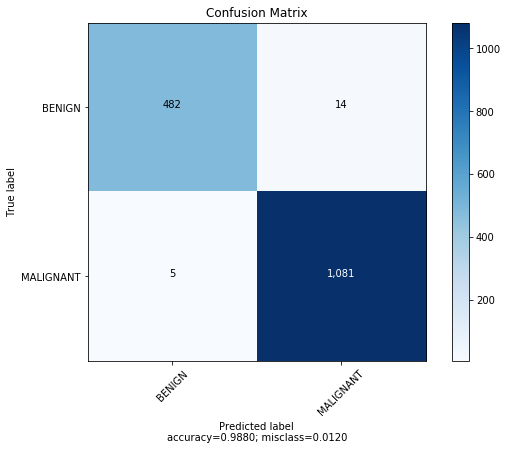

In [16]:
y_preds = threshold_arr(models[4].predict(x, verbose=0))

results = precision_recall_fscore_support(y, y_preds ,average='macro')
acc = accuracy_score(y, y_preds)

print("Accuracy: {}, F1_Score: {}, Precision: {}, Recall: {}".format(acc, results[2], results[0], results[1]))
print("\n")
print(classification_report(y, y_preds))
print("\n")
cnf_matrix = confusion_matrix(y.argmax(axis=1), y_preds.argmax(axis=1))

plot_confusion_matrix(cm           = cnf_matrix, 
                      normalize    = False,
                      target_names = ['BENIGN', 'MALIGNANT'],
                      title        = "Confusion Matrix")

In [18]:
import time
for i in range(5): 
    img = np.array(Image.open(BASE_DIR+"benign/SOB/adenosis/SOB_B_A_14-22549AB/40X/SOB_B_A-14-22549AB-40-009.png"))
    x = resize(img, SHAPE)
    x = x.reshape((1,) + x.shape) 
    start = time.time()
    prediction = models[4].predict(x, batch_size=1)
    finish = time.time()
    print(threshold_arr(prediction))
    print((finish-start)*1000,"ms")
    print("***")

[[1. 0.]]
115.65494537353516 ms
***
[[1. 0.]]
9.023904800415039 ms
***
[[1. 0.]]
9.061574935913086 ms
***
[[1. 0.]]
9.023904800415039 ms
***
[[1. 0.]]
8.55255126953125 ms
***
